In [129]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import math
import time

In [130]:
def hough_inter(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[math.cos(theta1), math.sin(theta1)], 
                  [math.cos(theta2), math.sin(theta2)]])
    b = np.array([rho1, rho2])
    ans = np.linalg.lstsq(A, b, rcond=None)[0]
    return (int(ans[0]), int(ans[1]))
    

In [131]:
def quadrilateral_area(p1, p2, p3, p4):
    return 0.5*((p1[0]*p2[1] + p2[0]*p3[1] + p3[0]*p4[1] + p4[0]*p1[1]) - (p2[0]*p1[1] + p3[0]*p2[1] + p4[0]*p3[1] + p1[0]*p4[1]))

In [132]:
#Given theta in radians
def close_to_verticle(theta):
    #verticle lines are integer multiples of pi/2
    PI_2 = math.pi / 2
    
    num = (abs(theta) / PI_2)
    closest_pi_over_2 = round(num)
    
    threshold = 0.05
    if abs(num - closest_pi_over_2) < threshold:
        return True
    
#Given theta in radians
def close_to_horizontal(theta):
    #horizontal lines are integer multiples of pi
    PI = math.pi
    
    num = (abs(theta) / PI)
    closest_pi = round(num)
    
    threshold = 0.1
    if abs(num - closest_pi) < threshold:
        return True

In [133]:
#Finds the lines that bound the mast
#If image parameter is supplied, it will draw the lines on that image
#returns (r, theta) pairs in order of LTRB
def find_bounding_lines(edges, image = None):
    leftLine = None
    rightLine = None
    topLine = None
    bottomLine = None
    
    lines = cv2.HoughLines(edges, 1, np.pi/180, 60)
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr
        
        #check if lines are sortve vertical or sortve horizontal and then see if they beat the extremes
        if close_to_horizontal(theta):
            if not leftLine:
                leftLine = (r, theta)
            elif abs(r) < abs(leftLine[0]):
                leftLine = (r, theta)
            
            if not rightLine:
                rightLine = (r, theta)
            elif abs(r) > abs(rightLine[0]):
                rightLine = (r, theta)
        elif close_to_verticle(theta):
            if not topLine:
                topLine = (r, theta)
            elif abs(r) < abs(topLine[0]):
                topLine = (r, theta)
                
            if not bottomLine:
                bottomLine = (r, theta)
            elif abs(r) > abs(bottomLine[0]):
                bottomLine = (r, theta)
    
    return leftLine, topLine, rightLine, bottomLine #left top right bottom

In [134]:
#### FILTER ALGORITHM ####
def algorithm(frame = 25):
    image = cv2.imread('mast_imgs/frame_{}.jpg'.format(frame))
    
    image = image[300:-200, 600:1500, :] #simulatin depth filter of the camera
    """
    m = np.zeros(image.shape[0:2])
    m = np.uint8(m)
    m[300:-200, 800:-300] = 1
    image=cv2.bitwise_and(image, image, mask = m)
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    

    # Do HSV Thresholding
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([60,35,140])
    upper_blue = np.array([190,255,255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(image, image, mask = mask)

    #Canny Edge Detection
    edges = cv2.Canny(result, 255/3, 255)

    lines = find_bounding_lines(edges=edges, image=None)

    left, top, right, bottom = lines

    #Display lines for debugging purposes
    for r, theta in lines:
        a = np.cos(theta); b = np.sin(theta)
        x0 = a*r; y0 = b*r
        x1 = int(x0 + 1000*(-b)); y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b)); y2 = int(y0 - 1000*(a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 10)

    TL_corner = hough_inter(top, left)
    TR_corner = hough_inter(top, right)
    BL_corner = hough_inter(bottom, left)
    BR_corner = hough_inter(bottom, right)

    cv2.circle(image, TL_corner, 10, 255, -1)
    cv2.circle(image, TR_corner, 10, 255, -1)
    cv2.circle(image, BL_corner, 10, 255, -1)
    cv2.circle(image, BR_corner, 10, 255, -1)
    
    
    #Plot Center 
    center = (int((TL_corner[0] + TR_corner[0] + BL_corner[0] + BR_corner[0])/4), int((TL_corner[1] + TR_corner[1] + BL_corner[1] + BR_corner[1])/4))
    cv2.circle(image, center, 5, (0, 120, 255), -1)
    
    #Get area
    area = quadrilateral_area(TL_corner, TR_corner, BR_corner, BL_corner)
    
    #Get offsets
    width, height, _ = image.shape
    image_center = (int(height/2), int(width/2))
    cv2.circle(image, image_center, 10, (255, 255, 0), -1)
    
    x_offset = center[0] - image_center[0]
    y_offset = center[1] - image_center[1]
    
    #Get Vanishing Point
    vanish_pt = hough_inter(top, bottom)
    
    print("CONTROL PARAMETERS:")
    print("  quad area: {}".format(area))
    print("  x offset: {}".format(x_offset))
    print("  y offset: {}".format(y_offset))
    print("  vanish pt: ({},{})".format(vanish_pt[0], vanish_pt[1]))
    
    return image, edges, np.array((TL_corner,TR_corner,BR_corner,BL_corner))

CONTROL PARAMETERS:
  quad area: 60393.0
  x offset: -32
  y offset: -6
  vanish pt: (7477,284)


(-0.5, 899.5, 579.5, -0.5)

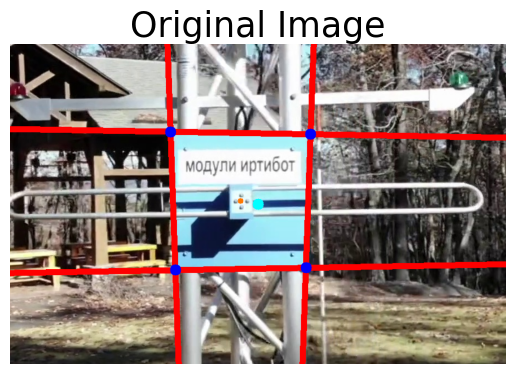

In [135]:
image,edges, corners = algorithm(frame = 68)
plt.imshow(image[:,:,::-1]);plt.title("Original Image",fontdict={'fontsize': 25});plt.axis('off')

In [136]:
#Print Out Edged Image
#plt.imshow(edges[:,:]);plt.title("Edged Image",fontdict={'fontsize': 25});plt.axis('off');

CONTROL PARAMETERS:
  quad area: 74756.0
  x offset: 303
  y offset: -15
  vanish pt: (4094,247)


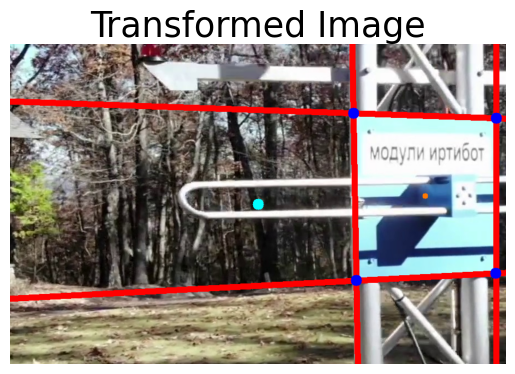

In [137]:
image_n, _, corners_n = algorithm(39)
plt.imshow(image_n[:,:,::-1]);plt.title("Transformed Image",fontdict={'fontsize': 25});plt.axis('off')
H, _ = cv2.findHomography(corners_n, corners)
num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(H, np.eye(3)) # use identity matrix as camera matric for now

In [138]:
#Not guranteed to work. Comparing plane normal might be better, but require more prior knowledge and augmentations 
possible_sol = []
oriP = np.hstack((corners_n,np.zeros(corners_n.shape[0])[:,np.newaxis]))
transformedP =  np.hstack((corners,np.zeros(corners.shape[0])[:,np.newaxis]))
for i in range(num):
    solV = True
    for j in range(oriP.shape[0]):
        oriDot = np.dot(oriP[j],Ns[i])
        curDot = np.dot(transformedP[j],np.matmul(Rs[i],Ns[i]))
        if oriDot<=0 or curDot<=0:
            solV = False
            break
    if solV:
        possible_sol.append(i)
print(possible_sol)
finSol = None
critera = quadrilateral_area(*corners)>=quadrilateral_area(*corners_n)
for i in possible_sol:
    if critera:
        if Ts[i][2]>=0:
            finSol = i
            print(i)
    else:
        if Ts[i][2]<0:
            finSol = i
            print(i)

print(finSol)

[1]
1
1
